In [10]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from datasets import load_dataset

# === BASE DIRECTORIES ===
BASE_DIR = "G:/My Drive/jbg060/01_data.lnk"
OUTPUT_DIR = "../coral_project_outputs"

# Dataset paths
PATH_BENTHIC = os.path.join(BASE_DIR, "benthic_datasets/mask_labels/reef_support")
PATH_CORALSEG = os.path.join(BASE_DIR, "benthic_datasets/mask_labels/Coralseg")
PATH_BLEACHING = os.path.join(BASE_DIR, "coral_bleaching/reef_support/UNAL_BLEACHING_TAYRONA")
PATH_CORALSCAPES = "ReefSupport/coralscapes"  # Hugging Face ID

In [11]:
# === OUTPUT FOLDERS ===
os.makedirs(os.path.join(OUTPUT_DIR, "manifests"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "processed_images"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "models"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "features"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "figures"), exist_ok=True)

print("Folders ready.")
print("BASE_DIR:", BASE_DIR)
print("OUTPUT_DIR:", OUTPUT_DIR)

# === QUICK DATASET AVAILABILITY CHECK ===
datasets = {
    "Benthic (Reef Support)": PATH_BENTHIC,
    "CoralSeg": PATH_CORALSEG,
    "Bleaching (UNAL)": PATH_BLEACHING,
}

for name, path in datasets.items():
    exists = os.path.exists(path)
    print(f"{'yes' if exists else 'no'} {name}: {path}")

# === Test load Hugging Face CoralScapes (requires login) ===
from datasets import load_dataset

try:
    print("Attempting to load CoralScapes from Hugging Face...")
    ds = load_dataset("EPFL-ECEO/coralscapes", split="train[:1%]")
    print(f"CoralScapes loaded successfully with {len(ds)} samples.")
    print("Available columns:", ds.column_names)
except Exception as e:
    print("Could not load CoralScapes automatically:", e)
    print("You may need to run: from huggingface_hub import login; login() first.")



Folders ready.
BASE_DIR: G:/My Drive/jbg060/01_data.lnk
OUTPUT_DIR: ../coral_project_outputs
yes Benthic (Reef Support): G:/My Drive/jbg060/01_data.lnk\benthic_datasets/mask_labels/reef_support
yes CoralSeg: G:/My Drive/jbg060/01_data.lnk\benthic_datasets/mask_labels/Coralseg
yes Bleaching (UNAL): G:/My Drive/jbg060/01_data.lnk\coral_bleaching/reef_support/UNAL_BLEACHING_TAYRONA
Attempting to load CoralScapes from Hugging Face...
CoralScapes loaded successfully with 15 samples.
Available columns: ['image', 'label']


In [12]:
import os
import glob
import pandas as pd
from tqdm import tqdm

BASE_DIR = "G:/My Drive/jbg060/01_data.lnk"
OUTPUT_DIR = "../coral_project_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def list_image_mask_pairs(image_dir, mask_dir, dataset_name, site=None):
    """Return a dataframe linking image and mask paths."""
    images = sorted(glob.glob(os.path.join(image_dir, "*")))
    masks  = sorted(glob.glob(os.path.join(mask_dir, "*")))
    # Match by filename (without extension)
    mapping = []
    for img in images:
        base = os.path.splitext(os.path.basename(img))[0]
        match = [m for m in masks if base in m]
        if match:
            mapping.append((dataset_name, site or dataset_name, img, match[0]))
    return pd.DataFrame(mapping, columns=["dataset", "site", "image_path", "mask_path"])


In [14]:
# Section 2.1: Load all datasets (Unified Integration)

import os, glob, cv2, numpy as np, pandas as pd
from tqdm import tqdm
from datasets import load_dataset

BASE_DIR = "G:/My Drive/jbg060/01_data.lnk"
OUTPUT_DIR = "../coral_project_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def list_image_mask_pairs(image_dir, mask_dir, dataset_name, site=None):
    """Return a dataframe linking image and mask paths."""
    images = sorted(glob.glob(os.path.join(image_dir, "*")))
    masks  = sorted(glob.glob(os.path.join(mask_dir, "*")))
    mapping = []
    for img in images:
        base = os.path.splitext(os.path.basename(img))[0]
        match = [m for m in masks if base in m]
        if match:
            mapping.append((dataset_name, site or dataset_name, img, match[0]))
    return pd.DataFrame(mapping, columns=["dataset", "site", "image_path", "mask_path"])


# 1. Reef Support: Benthic
reef_root = f"{BASE_DIR}/benthic_datasets/mask_labels/reef_support"
benthic_records = []

for site in os.listdir(reef_root):
    site_path = os.path.join(reef_root, site)
    if not os.path.isdir(site_path):
        continue

    img_dir = os.path.join(site_path, "images")
    mask_dir = os.path.join(site_path, "masks_stitched")  # stitched = hard + soft coral combined

    if os.path.exists(img_dir) and os.path.exists(mask_dir):
        df_site = list_image_mask_pairs(img_dir, mask_dir, "benthic", site)
        benthic_records.append(df_site)

df_benthic = pd.concat(benthic_records, ignore_index=True)
print(f" Benthic dataset loaded: {len(df_benthic)} samples across {len(benthic_records)} sites.")


# 2. Bleaching Dataset (UNAL)
bleach_root = f"{BASE_DIR}/coral_bleaching/reef_support/UNAL_BLEACHING_TAYRONA"
bleach_records = []

for label_dir in ["masks_bleached", "masks_non_bleached"]:
    label = "bleached" if "bleached" in label_dir else "non_bleached"
    mask_dir = os.path.join(bleach_root, label_dir)
    img_dir = os.path.join(bleach_root, "images")

    if os.path.exists(mask_dir):
        df_label = list_image_mask_pairs(img_dir, mask_dir, "bleaching_UNAL", label)
        bleach_records.append(df_label)

df_bleach = pd.concat(bleach_records, ignore_index=True)
print(f" Bleaching dataset loaded: {len(df_bleach)} samples.")


# 3. CoralSeg
coralseg_root = f"{BASE_DIR}/benthic_datasets/mask_labels/Coralseg"
coralseg_records = []

for split in ["train", "val", "test"]:
    img_dir = os.path.join(coralseg_root, split, "Image")
    mask_dir = os.path.join(coralseg_root, split, "Mask")
    if os.path.exists(img_dir) and os.path.exists(mask_dir):
        df_split = list_image_mask_pairs(img_dir, mask_dir, "coralseg", split)
        coralseg_records.append(df_split)

if len(coralseg_records) > 0:
    df_coralseg = pd.concat(coralseg_records, ignore_index=True)
    print(f" CoralSeg dataset loaded: {len(df_coralseg)} samples across splits.")
else:
    df_coralseg = pd.DataFrame(columns=["dataset", "site", "image_path", "mask_path"])
    print(" CoralSeg dataset not found or empty.")


# 4. CoralScapes (Hugging Face)
print("Downloading CoralScapes dataset...")
from datasets import load_dataset

save_dir = "../coral_project_outputs/content/coralscapes_local"
os.makedirs(os.path.join(save_dir, "images"), exist_ok=True)
os.makedirs(os.path.join(save_dir, "masks"), exist_ok=True)

try:
    ds = load_dataset("EPFL-ECEO/coralscapes", split="train")
except Exception as e:
    print("Could not load dataset normally. Trying with streaming mode...")
    ds = load_dataset("EPFL-ECEO/coralscapes", split="train", streaming=True)

first_sample = next(iter(ds))
print("\n CoralScapes sample keys:", list(first_sample.keys()))

# Detect correct image and mask field names
mask_key = None
for k in first_sample.keys():
    if any(sub in k.lower() for sub in ["mask", "segmentation", "annotation", "label"]):
        mask_key = k
        break

if mask_key is None:
    print("⚠️ Defaulting to 'label' field as mask source (based on dataset card).")
    mask_key = "label"

print(f" Found mask field: '{mask_key}'")


print(f" Found mask field: '{mask_key}'")

# Save locally
print(" Saving CoralScapes images and masks locally...")
for i, sample in tqdm(enumerate(ds), total=1500):
    try:
        img = np.array(sample["image"])
        mask = np.array(sample[mask_key])
        cv2.imwrite(f"{save_dir}/images/coralscape_{i:05d}.png", cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        cv2.imwrite(f"{save_dir}/masks/coralscape_{i:05d}.png", mask)
    except Exception as e:
        print(f" Skipping sample {i}: {e}")
        continue

print(" CoralScapes exported locally:", save_dir)

# Build dataframe
df_coralscapes = list_image_mask_pairs(
    os.path.join(save_dir, "images"),
    os.path.join(save_dir, "masks"),
    "coralscapes",
    "coralscapes"
)
print(f" CoralScapes dataset loaded: {len(df_coralscapes)} samples.")



# --- Merge All Datasets ---
df_all = pd.concat([df_benthic, df_bleach, df_coralseg, df_coralscapes], ignore_index=True)
print("\n Unified dataset summary:")
print(df_all["dataset"].value_counts())
print(f"\n Unified dataset created with {len(df_all)} total samples.")


 Benthic dataset loaded: 3319 samples across 8 sites.
 Bleaching dataset loaded: 1316 samples.
 CoralSeg dataset loaded: 4925 samples across splits.

 CoralScapes sample keys: ['image', 'label']
 Found mask field: 'label'
 Found mask field: 'label'
 Saving CoralScapes images and masks locally...


1517it [03:39,  6.91it/s]                          


 CoralScapes exported locally: ../coral_project_outputs/content/coralscapes_local
 CoralScapes dataset loaded: 1517 samples.

 Unified dataset summary:
dataset
coralseg          4925
benthic           3319
coralscapes       1517
bleaching_UNAL    1316
Name: count, dtype: int64

 Unified dataset created with 11077 total samples.


In [16]:
# Section 2.2: Normalize all datasets to binary coral vs non-coral

import os, cv2, numpy as np
from tqdm import tqdm

norm_dir = f"{OUTPUT_DIR}/normalized_masks"
os.makedirs(norm_dir, exist_ok=True)

# Define coral-related class IDs for CoralScapes
CORALSCAPES_CORAL_CLASSES = [
    3, 4, 6, 16, 17, 19, 20, 21, 22, 23, 25, 27, 28, 31, 32, 33, 34, 36, 37
]

def normalize_mask(mask_path, dataset):
    """
    Converts mask to binary coral vs non-coral (0/255).
    Handles CoralScapes (multi-class) and other datasets (grayscale).
    """
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        return None

    if dataset == "coralscapes":
        mask_bin = np.isin(mask, CORALSCAPES_CORAL_CLASSES).astype(np.uint8) * 255
    else:
        mask_bin = (mask > 0).astype(np.uint8) * 255

    return mask_bin

updated_paths, status_paths = [], []

print("Normalizing all datasets to binary coral/non-coral masks...")
for i, row in tqdm(df_all.iterrows(), total=len(df_all)):
    ds = row["dataset"]
    mask_path = row["mask_path"]

    try:
        mask_bin = normalize_mask(mask_path, ds)
        if mask_bin is None:
            updated_paths.append(None)
            status_paths.append(None)
            continue

        out_path = os.path.join(norm_dir, f"{ds}_{i:06d}_binary.png")
        cv2.imwrite(out_path, mask_bin)
        updated_paths.append(out_path)

        # Keep CoralScapes status map if it exists
        if "mask_status_path" in df_all.columns and not pd.isna(row.get("mask_status_path", np.nan)):
            status_paths.append(row["mask_status_path"])
        else:
            status_paths.append(None)

    except Exception as e:
        print(f"⚠️ Error processing {mask_path}: {e}")
        updated_paths.append(None)
        status_paths.append(None)

df_all["mask_binary_path"] = updated_paths
df_all["mask_status_path"] = status_paths

print(f"Normalization complete. {df_all['mask_binary_path'].notna().sum()} masks saved.")
df_all.to_csv(f"{OUTPUT_DIR}/merged_dataset.csv", index=False)
print(f"Saved merged dataset manifest to: {OUTPUT_DIR}/merged_dataset.csv")


Normalizing all datasets to binary coral/non-coral masks...


100%|██████████| 11077/11077 [07:51<00:00, 23.48it/s]

Normalization complete. 11066 masks saved.
Saved merged dataset manifest to: ../coral_project_outputs/merged_dataset.csv


In [17]:
final_csv = f"{OUTPUT_DIR}/merged_dataset_normalized.csv"
df_all.to_csv(final_csv, index=False)
print(f"Saved unified dataset manifest to: {final_csv}")
print("Total samples:", len(df_all))
print(df_all["dataset"].value_counts())


Saved unified dataset manifest to: ../coral_project_outputs/merged_dataset_normalized.csv
Total samples: 11077
dataset
coralseg          4925
benthic           3319
coralscapes       1517
bleaching_UNAL    1316
Name: count, dtype: int64


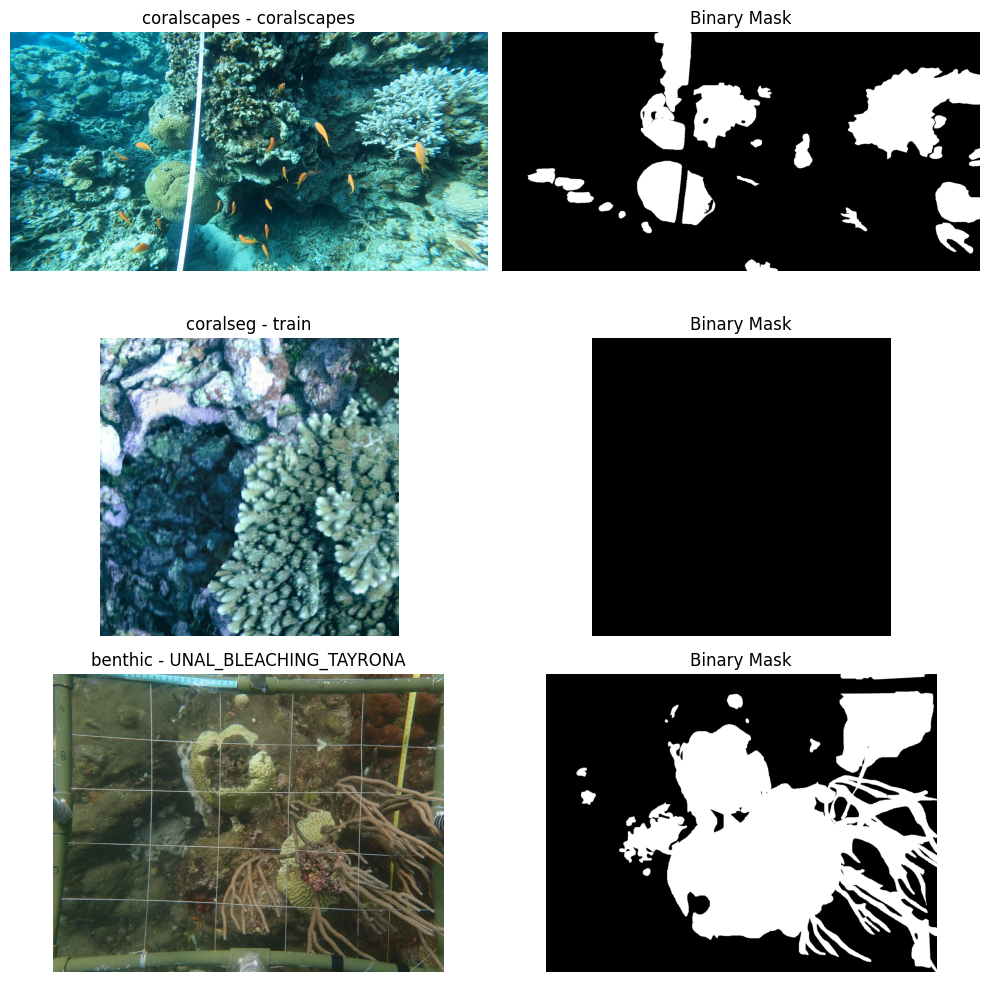

In [18]:
import random
import matplotlib.pyplot as plt

samples = df_all.sample(3)
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

for i, (_, row) in enumerate(samples.iterrows()):
    img = cv2.imread(row["image_path"])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(row["mask_binary_path"], cv2.IMREAD_GRAYSCALE)

    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f"{row['dataset']} - {row['site']}")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(mask, cmap="gray")
    axes[i, 1].set_title("Binary Mask")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

In [19]:
# Section 3.1: Load Unified Dataset

import os, cv2, numpy as np, pandas as pd
from tqdm import tqdm

# Reload merged dataset
merged_csv = f"{OUTPUT_DIR}/merged_dataset_normalized.csv"
df = pd.read_csv(merged_csv)

print("Loaded merged dataset:", df.shape)
print(df.head(2))


Loaded merged dataset: (11077, 6)
   dataset             site  \
0  benthic  SEAVIEW_IDN_PHL   
1  benthic  SEAVIEW_IDN_PHL   

                                          image_path  \
0  G:/My Drive/jbg060/01_data.lnk/benthic_dataset...   
1  G:/My Drive/jbg060/01_data.lnk/benthic_dataset...   

                                           mask_path  \
0  G:/My Drive/jbg060/01_data.lnk/benthic_dataset...   
1  G:/My Drive/jbg060/01_data.lnk/benthic_dataset...   

                                    mask_binary_path  mask_status_path  
0  ../coral_project_outputs/normalized_masks\bent...               NaN  
1  ../coral_project_outputs/normalized_masks\bent...               NaN  


In [20]:
# Section 3.2: Remove empty / invalid masks

valid_rows = []
coverage = []

print("...Checking for empty or invalid masks...")
for _, row in tqdm(df.iterrows(), total=len(df)):
    mask = cv2.imread(str(row["mask_binary_path"]), cv2.IMREAD_GRAYSCALE)
    if mask is None:
        continue
    coral_pixels = np.count_nonzero(mask)
    coral_ratio = coral_pixels / (mask.shape[0]*mask.shape[1])
    if coral_pixels > 0:  # only non-empty
        valid_rows.append(row)
        coverage.append(coral_ratio)

df_clean = pd.DataFrame(valid_rows)
df_clean["coral_ratio"] = coverage

print(f"Remaining valid samples: {len(df_clean)} ({len(df_clean)/len(df)*100:.1f}% kept)")


...Checking for empty or invalid masks...


100%|██████████| 11077/11077 [03:04<00:00, 60.03it/s] 

Remaining valid samples: 5845 (52.8% kept)


In [21]:
# Section 3.3: Filter small coral regions

threshold = 0.01  # coral covers at least 1% of image
df_clean = df_clean[df_clean["coral_ratio"] > threshold].reset_index(drop=True)

print(f"Samples after removing small coral areas: {len(df_clean)}")


Samples after removing small coral areas: 5523


In [22]:
import os
import cv2
from tqdm import tqdm
import pandas as pd

# Directory to store resized data
RESIZED_DIR = os.path.join(OUTPUT_DIR, "resized_data")
os.makedirs(RESIZED_DIR, exist_ok=True)

new_records = []

for i, row in tqdm(df_clean.iterrows(), total=len(df_clean), desc="Resizing images and masks to 512x512"):
    try:
        img = cv2.imread(row["image_path"])
        mask = cv2.imread(row["mask_path"], cv2.IMREAD_GRAYSCALE)

        # Skip invalid pairs
        if img is None or mask is None:
            continue

        # Output paths
        base = os.path.splitext(os.path.basename(row["image_path"]))[0]
        img_out = os.path.join(RESIZED_DIR, f"{base}_img.png")
        mask_out = os.path.join(RESIZED_DIR, f"{base}_mask.png")

        # Skip if already resized
        if os.path.exists(img_out) and os.path.exists(mask_out):
            new_records.append({
                "dataset": row["dataset"],
                "site": row["site"],
                "image_resized": img_out,
                "mask_resized": mask_out
            })
            continue

        # Resize and save
        img_resized = cv2.resize(img, (512, 512))
        mask_resized = cv2.resize(mask, (512, 512))
        cv2.imwrite(img_out, img_resized)
        cv2.imwrite(mask_out, mask_resized)

        new_records.append({
            "dataset": row["dataset"],
            "site": row["site"],
            "image_resized": img_out,
            "mask_resized": mask_out
        })

    except Exception as e:
        print(f"Error resizing {row['image_path']}: {e}")
        continue

# Build new DataFrame from successful resizes
df_resized = pd.DataFrame(new_records)
print(f"Resized successfully: {len(df_resized)} / {len(df_clean)} samples")

# Save manifest
resized_csv = os.path.join(OUTPUT_DIR, "df_resized_manifest.csv")
df_resized.to_csv(resized_csv, index=False)
print(f"Manifest saved to: {resized_csv}")


Resizing images and masks to 512x512: 100%|██████████| 5523/5523 [11:56<00:00,  7.71it/s]

Resized successfully: 5523 / 5523 samples
Manifest saved to: ../coral_project_outputs\df_resized_manifest.csv


In [23]:
# Section 3.5: Site-Stratified Split

from sklearn.model_selection import train_test_split

train_list, val_list, test_list = [], [], []

for site, group in df_resized.groupby("site"):
    if len(group) < 10:  # skip tiny sites
        continue
    train, temp = train_test_split(group, test_size=0.3, random_state=42)
    val, test = train_test_split(temp, test_size=0.5, random_state=42)
    train_list.append(train)
    val_list.append(val)
    test_list.append(test)

df_train = pd.concat(train_list)
df_val   = pd.concat(val_list)
df_test  = pd.concat(test_list)

print(f"Train: {len(df_train)}, Val: {len(df_val)}, Test: {len(df_test)}")


Train: 3863, Val: 828, Test: 832


In [24]:
# Save Clean Dataset

split_dir = os.path.join(OUTPUT_DIR, "dataset_splits")
os.makedirs(split_dir, exist_ok=True)

df_train.to_csv(f"{split_dir}/train_manifest.csv", index=False)
df_val.to_csv(f"{split_dir}/val_manifest.csv", index=False)
df_test.to_csv(f"{split_dir}/test_manifest.csv", index=False)

print("Succesfully saved manifests to:", split_dir)


Succesfully saved manifests to: ../coral_project_outputs\dataset_splits


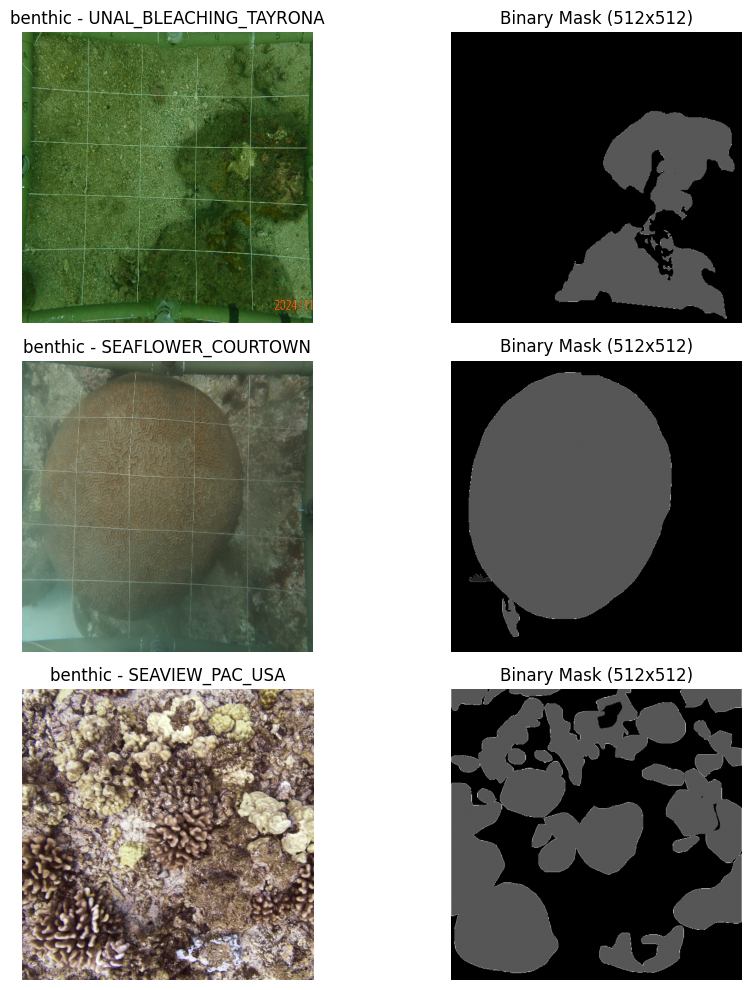

In [25]:
# Section 3.6: Visual Sanity Check

import random
import matplotlib.pyplot as plt

samples = df_resized.sample(3)
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
for i, (_, row) in enumerate(samples.iterrows()):
    img = cv2.imread(row["image_resized"])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(row["mask_resized"], cv2.IMREAD_GRAYSCALE)
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f"{row['dataset']} - {row['site']}")
    axes[i, 0].axis("off")
    axes[i, 1].imshow(mask, cmap="gray")
    axes[i, 1].set_title("Binary Mask (512x512)")
    axes[i, 1].axis("off")
plt.tight_layout()
plt.show()


In [26]:
# Section 4: Model Setup & Training

# Core imports
import os
import cv2
import time
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# ML / Vision imports
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp

# Paths
BASE_DIR = "G:/My Drive/jbg060/01_data.lnk"
OUTPUT_DIR = "../coral_project_outputs"
SPLIT_DIR = f"{OUTPUT_DIR}/dataset_splits"

# Dataset manifests
train_csv = os.path.join(SPLIT_DIR, "train_manifest.csv")
val_csv   = os.path.join(SPLIT_DIR, "val_manifest.csv")

df_train = pd.read_csv(train_csv)
df_val   = pd.read_csv(val_csv)

print(f"Loaded manifests | Train: {len(df_train)} | Val: {len(df_val)}")

# GPU Check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Loaded manifests | Train: 3863 | Val: 828
Using device: cuda


In [27]:
# Section 4.2: Dataset & DataLoader

from coralsegdataset import CoralSegDataset

# Create loaders
train_ds = CoralSegDataset(df_train, augment=True)
val_ds   = CoralSegDataset(df_val, augment=False)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=2)

batch = next(iter(train_loader))
print("Dataloader OK — imgs:", batch[0].shape, "| masks:", batch[1].shape)


c:\Users\timow\Documents\School\GitHub\JBG060_G13\notebooks\coralsegdataset.py:25: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=32, max_width=32, fill_value=0, p=0.3),


Dataloader OK — imgs: torch.Size([8, 3, 512, 512]) | masks: torch.Size([8, 1, 512, 512])


In [30]:
# Section 4.3: Model, Loss & Optimizer

ENCODER = "efficientnet-b0"
ENCODER_WEIGHTS = "imagenet"

model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    in_channels=3,
    classes=1,
    activation=None
).to(device)

# Loss: BCE + Dice
bce = torch.nn.BCEWithLogitsLoss()
dice = smp.losses.DiceLoss(mode="binary")

def combined_loss(pred, target):
    return 0.5 * bce(pred, target) + 0.5 * dice(pred, target)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)



In [33]:
# 4.4: Training Loop (with fixed combined loss)

def compute_iou(preds, masks, threshold=0.5):
    preds = (preds > threshold).float()
    intersection = (preds * masks).sum(dim=(1,2,3))
    union = preds.sum(dim=(1,2,3)) + masks.sum(dim=(1,2,3)) - intersection
    return (intersection / (union + 1e-7)).mean().item()

EPOCHS = 30
best_iou = 0
train_history, val_history = [], []

for epoch in range(EPOCHS):
    model.train()
    train_loss = []
    for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        loss = combined_loss(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    # Validation
    model.eval()
    val_loss, val_iou = [], []
    with torch.no_grad():
        for imgs, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            loss = combined_loss(preds, masks)
            val_loss.append(loss.item())
            val_iou.append(compute_iou(torch.sigmoid(preds), masks))

    mean_train, mean_val, mean_iou = np.mean(train_loss), np.mean(val_loss), np.mean(val_iou)
    train_history.append(mean_train)
    val_history.append(mean_val)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train: {mean_train:.4f} | Val: {mean_val:.4f} | IoU: {mean_iou:.4f}")

    # LR scheduler reacts to validation IoU
    scheduler.step(mean_iou)

    # Save best model
    if mean_iou > best_iou:
        best_iou = mean_iou
        torch.save(model.state_dict(), f"{OUTPUT_DIR}/best_model.pth")
        print("💾 Saved new best model.")

print("Training complete! Best IoU:", best_iou)


Epoch 1/30 [Val]: 100%|██████████| 104/104 [00:12<00:00,  8.32it/s]


Epoch 1/30 | Train: 0.4558 | Val: 0.3576 | IoU: 0.0306
💾 Saved new best model.


Epoch 2/30 [Val]: 100%|██████████| 104/104 [00:14<00:00,  7.14it/s]


Epoch 2/30 | Train: 0.4503 | Val: 0.3530 | IoU: 0.0341
💾 Saved new best model.


Epoch 3/30 [Val]: 100%|██████████| 104/104 [00:12<00:00,  8.12it/s]


Epoch 3/30 | Train: 0.4486 | Val: 0.3507 | IoU: 0.0364
💾 Saved new best model.


Epoch 4/30 [Val]: 100%|██████████| 104/104 [00:12<00:00,  8.48it/s]


Epoch 4/30 | Train: 0.4457 | Val: 0.3486 | IoU: 0.0388
💾 Saved new best model.


Epoch 5/30 [Val]: 100%|██████████| 104/104 [00:12<00:00,  8.35it/s]


Epoch 5/30 | Train: 0.4425 | Val: 0.3501 | IoU: 0.0370


Epoch 6/30 [Val]: 100%|██████████| 104/104 [00:12<00:00,  8.24it/s]


Epoch 6/30 | Train: 0.4432 | Val: 0.3536 | IoU: 0.0362


Epoch 7/30 [Val]: 100%|██████████| 104/104 [00:11<00:00,  9.11it/s]


Epoch 7/30 | Train: 0.4396 | Val: 0.3506 | IoU: 0.0386


Epoch 8/30 [Val]: 100%|██████████| 104/104 [00:12<00:00,  8.50it/s]


Epoch 8/30 | Train: 0.4386 | Val: 0.3484 | IoU: 0.0402
💾 Saved new best model.


Epoch 9/30 [Val]: 100%|██████████| 104/104 [00:11<00:00,  8.72it/s]


Epoch 9/30 | Train: 0.4376 | Val: 0.3504 | IoU: 0.0383


Epoch 10/30 [Val]: 100%|██████████| 104/104 [00:12<00:00,  8.26it/s]


Epoch 10/30 | Train: 0.4381 | Val: 0.3484 | IoU: 0.0396


Epoch 11/30 [Val]: 100%|██████████| 104/104 [00:12<00:00,  8.22it/s]


Epoch 11/30 | Train: 0.4345 | Val: 0.3532 | IoU: 0.0343


Epoch 12/30 [Val]: 100%|██████████| 104/104 [00:11<00:00,  9.10it/s]


Epoch 12/30 | Train: 0.4342 | Val: 0.3506 | IoU: 0.0378


Epoch 13/30 [Val]: 100%|██████████| 104/104 [00:11<00:00,  8.81it/s]


Epoch 13/30 | Train: 0.4325 | Val: 0.3467 | IoU: 0.0406
💾 Saved new best model.


Epoch 14/30 [Val]: 100%|██████████| 104/104 [00:12<00:00,  8.38it/s]


Epoch 14/30 | Train: 0.4311 | Val: 0.3472 | IoU: 0.0397


Epoch 15/30 [Val]: 100%|██████████| 104/104 [00:13<00:00,  7.99it/s]


Epoch 15/30 | Train: 0.4294 | Val: 0.3485 | IoU: 0.0391


Epoch 16/30 [Val]: 100%|██████████| 104/104 [00:12<00:00,  8.54it/s]


Epoch 16/30 | Train: 0.4302 | Val: 0.3471 | IoU: 0.0412
💾 Saved new best model.


Epoch 17/30 [Val]: 100%|██████████| 104/104 [00:12<00:00,  8.46it/s]


Epoch 17/30 | Train: 0.4294 | Val: 0.3454 | IoU: 0.0412
💾 Saved new best model.


Epoch 18/30 [Val]: 100%|██████████| 104/104 [00:12<00:00,  8.46it/s]


Epoch 18/30 | Train: 0.4281 | Val: 0.3445 | IoU: 0.0431
💾 Saved new best model.


Epoch 19/30 [Val]: 100%|██████████| 104/104 [00:14<00:00,  7.41it/s]


Epoch 19/30 | Train: 0.4282 | Val: 0.3467 | IoU: 0.0397


Epoch 20/30 [Val]: 100%|██████████| 104/104 [00:11<00:00,  8.67it/s]


Epoch 20/30 | Train: 0.4272 | Val: 0.3470 | IoU: 0.0406


Epoch 21/30 [Val]: 100%|██████████| 104/104 [00:11<00:00,  8.68it/s]


Epoch 21/30 | Train: 0.4279 | Val: 0.3453 | IoU: 0.0413


Epoch 22/30 [Val]: 100%|██████████| 104/104 [00:12<00:00,  8.53it/s]


Epoch 22/30 | Train: 0.4276 | Val: 0.3443 | IoU: 0.0421


Epoch 23/30 [Val]: 100%|██████████| 104/104 [00:12<00:00,  8.30it/s]


Epoch 23/30 | Train: 0.4257 | Val: 0.3460 | IoU: 0.0413


Epoch 24/30 [Val]: 100%|██████████| 104/104 [00:13<00:00,  7.92it/s]


Epoch 24/30 | Train: 0.4253 | Val: 0.3452 | IoU: 0.0417


Epoch 25/30 [Val]: 100%|██████████| 104/104 [00:12<00:00,  8.14it/s]


Epoch 25/30 | Train: 0.4244 | Val: 0.3456 | IoU: 0.0406


Epoch 26/30 [Val]: 100%|██████████| 104/104 [00:12<00:00,  8.23it/s]


Epoch 26/30 | Train: 0.4248 | Val: 0.3449 | IoU: 0.0417


Epoch 27/30 [Val]: 100%|██████████| 104/104 [00:13<00:00,  7.76it/s]


Epoch 27/30 | Train: 0.4246 | Val: 0.3449 | IoU: 0.0416


Epoch 28/30 [Val]: 100%|██████████| 104/104 [00:12<00:00,  8.35it/s]


Epoch 28/30 | Train: 0.4245 | Val: 0.3454 | IoU: 0.0409


Epoch 29/30 [Val]: 100%|██████████| 104/104 [00:12<00:00,  8.37it/s]


Epoch 29/30 | Train: 0.4246 | Val: 0.3457 | IoU: 0.0410


Epoch 30/30 [Val]: 100%|██████████| 104/104 [00:14<00:00,  7.14it/s]

Epoch 30/30 | Train: 0.4236 | Val: 0.3454 | IoU: 0.0411
Training complete! Best IoU: 0.04311627478455193


In [ ]:
# Section 4.5: Visualization of Predictions

model.eval()
samples = random.sample(range(len(val_ds)), 3)
fig, axes = plt.subplots(len(samples), 3, figsize=(12, 10))

for i, idx in enumerate(samples):
    img, mask = val_ds[idx]
    img_np = img.permute(1,2,0).cpu().numpy()
    pred = torch.sigmoid(model(img.unsqueeze(0).to(device))).cpu().detach().squeeze().numpy()

    axes[i,0].imshow(img_np)
    axes[i,0].set_title("Original Image"); axes[i,0].axis("off")

    axes[i,1].imshow(mask.squeeze(), cmap="gray")
    axes[i,1].set_title("Ground Truth Mask"); axes[i,1].axis("off")

    axes[i,2].imshow(pred > 0.5, cmap="gray")
    axes[i,2].set_title("Predicted Mask"); axes[i,2].axis("off")

plt.tight_layout()
plt.show()
